# Does scene classification help cropland models?

**Problem**: Cropland classification models based on single pixel time series have trouble distinguishing between crops and shrubs (chaparral) which have similar NDVI signatures.

**Key idea**: use high resolution maps to improve cropland classification using single pixel time series.


1. [x] Existing work (crop classification, scene classification)
2. [x] Existing datasets
3. [x] Getting data related to crop-mask labels
4. [x] Organize dataset
5. [x] Create dataloader
6. [x] Make baseline model that classifies scenes as crop/non-crop (ResNet?) / data augmentation
7. [ ] Decide on which model to use (best models on scene classification datasets)
8. [ ] Evaluate performance (is crop and shrub failure mode addressed?)

# 1. Existing Work
### Existing cropland models

Rapid Response Crop Maps in Data Sparse Regions
- Model: Pixel-based LSTM
- Data: Sentinel-2
- Resolution: 10m
- Region: Togo

Global Food Security-support Analysis Data (GFSAD)
- Model: Pixel-based random forest and pixel-based SVM, and a Recursive Hierarchical Image Segmentation classifier?
- Data: ?
- Resolution: 30m
- Region: Africa
- Note: Available for 2015 only

Copernicus Map
- Model: Random forests + expert rule
- Data: PROBA-V sensor
- Resolution: 100m
- Note: Available for 2018
- Region: Togo?

Crop Area Mapping in Southern and Central Malawi With Google Earth Engine
- Model: Random forest
- Data: Sentinel-2 with Spectral Mixture Analysis
- Resolution: 10m
- Region: Malawi

Estimating Global Cropland Extent with Multi-year MODIS Data
- Model: Some sort of decision tree
- Data: MODIS
- Resolution: 250m
- Region: THE WORLD

### Models for classifying high resolution imagery
Good overview of scene classification: https://arxiv.org/abs/2005.01094

# 2. Existing scene classification datasets
Specifically looking for:
- [ ] Should have crop/field class
- [ ] Should have lot's of images
- [ ] Should have high resolution images (ideally constant resolution <10m)
- [ ] Should have images gathered from Africa

From overview paper:
- [ ] UC Merced - US only
- [ ] SAT-4 and SAT-6 airborne datasets - US only
- [x] NWPU-RESISC45 - data source Google Earth
- [x] AID - data source Google Earth

https://github.com/chrieke/awesome-satellite-imagery-datasets#4-scene-classification
- [ ] fMow - too complicated https://github.com/fMoW/dataset

NWPU-RESISC45
- 45 classes, 700 images per class
- Relevant classes: chaparral, circular_farmland, desert, forest, meadow, mountains, rectangular_farmland, terrace, wetland
- Image size: 256x256
- Resolution: 0.2 - 30m, can deal with this by getting XYZ tiles with multiple zoom levels
- Concern: Some classes ie mountain have even lower resolution
- Year: 2016

AID
- Concern: mainly in China, the United States, England, France, Italy, Japan, Germany
- 30 classes, 200 to 400 samples of size 
- Image size: 600x600

So far NWPU-RESISC45 seems like best option. Also because XYZ tiles are 256x256 by default.

# 3. Getting data related to crop-mask labels

I have coordinates for a bunch of points, I need to get a 256x256 Google Satellite image for each of those

URLs: https://opensourceoptions.com/blog/how-to-add-google-satellite-imagery-and-google-maps-to-qgis/

### Candidates
Zoom: 16

<img src="https://mt0.google.com/vt/lyrs=s&hl=en&x=38833&y=32489&z=16" 
     width="30%" 
     align="left" 
     style="padding: 0 1em"/>

Zoom: 17

<img src="https://mt0.google.com/vt/lyrs=s&hl=en&x=77668&y=64979&z=17" 
     width="30%" 
     align="left" 
     style="padding: 0 1em"/>
     
Zoom: 18

<img src="https://mt0.google.com/vt/lyrs=s&hl=en&x=155336&y=129959&z=18" 
     width="30%" 
     align="left" 
     style="padding: 0 1em"/>
But how to get tile XYZ from coordinate?

In [1]:
!pip install pyGeoTile -q

In [2]:
from pygeotile.tile import Tile
from IPython.display import Image as IPythonImage
from IPython.core.display import HTML

In [3]:
latitude = 10.064603
longitude = 16.903645
imgs = {}
for zoom in [13, 14, 15, 16, 17, 18, 19, 20, 21]:
    tile = Tile.for_latitude_longitude(latitude, longitude, zoom)
    img = IPythonImage(url=f"https://mt0.google.com/vt/lyrs=s&hl=en&x={tile.google[0]}&y={tile.google[1]}&z={zoom}")
    imgs[zoom] = img

display(*list(imgs.values()))

# Combining Labels with tile URLs

In [6]:
from tqdm.notebook import tqdm
import pandas as pd
import sys
sys.path.append("..")
from src.datasets_labeled import labeled_datasets
from src.ETL.constants import LAT, LON, SUBSET
from notebook_utils import get_validation_df

In [45]:
ds = [
    "Ethiopia_Tigray_2020",
    #"Ethiopia_Tigray_2021",
    "geowiki_landcover_2017",
    "digitalearthafrica_eastern",
    "Ethiopia",
    "Kenya",
    "Mali",
    "Rwanda",
    "Togo",
    "Ethiopia_Bure_Jimma_2019",
    "Ethiopia_Bure_Jimma_2020",
]

labels = pd.concat([d.load_labels() for d in labeled_datasets if d.dataset in ds])

In [46]:
labels.head()

,lon,lat,start_date,end_date,source,crop_probability,num_labelers,subset,crop_type,country,dataset,filename,feature_dir,save_path,already_exists
0,46.25,-16.547619,2017-01-01,2018-12-31,loc_all_2.txt,0.000000,1,training,NaN,global,geowiki_landcover_2017,lat=-16.54761905_lon=46.25_date=2017-01-01_201...,../data/features,../data/features/lat=-16.54761905_lon=46.25_da...,True
1,48.25,-18.547619,2017-01-01,2018-12-31,loc_all_2.txt,0.136000,1,training,NaN,global,geowiki_landcover_2017,lat=-18.54761905_lon=48.25_date=2017-01-01_201...,../data/features,../data/features/lat=-18.54761905_lon=48.25_da...,True
2,44.25,-21.547619,2017-01-01,2018-12-31,loc_all_2.txt,0.000000,1,training,NaN,global,geowiki_landcover_2017,lat=-21.54761905_lon=44.25_date=2017-01-01_201...,../data/features,../data/features/lat=-21.54761905_lon=44.25_da...,True
3,45.25,-17.547619,2017-01-01,2018-12-31,loc_all_2.txt,0.073333,1,training,NaN,global,geowiki_landcover_2017,lat=-17.54761905_lon=45.25_date=2017-01-01_201...,../data/features,../data/features/lat=-17.54761905_lon=45.25_da...,True
4,46.25,-21.547619,2017-01-01,2018-12-31,loc_all_2.txt,0.000000,1,training,NaN,global,geowiki_landcover_2017,lat=-21.54761905_lon=46.25_date=2017-01-01_201...,../data/features,../data/features/lat=-21.54761905_lon=46.25_da...,True


In [47]:
# Create URLs for each zoom level
def get_url_from_latlon(latitude, longitude, zoom):
    tile = Tile.for_latitude_longitude(latitude, longitude, zoom)
    return f"https://mt0.google.com/vt/lyrs=s&hl=en&x={tile.google[0]}&y={tile.google[1]}&z={zoom}"

zoom_levels = [13, 14, 15, 16, 17, 18, 19, 20, 21]
for zoom in tqdm(zoom_levels):
    labels[f"XYZ_zoom_{zoom}"] = labels.apply(lambda row: get_url_from_latlon(row[LAT], row[LON], zoom), axis=1)

  0%|          | 0/9 [00:00<?, ?it/s]

In [48]:
urls = [labels.iloc[0][f"XYZ_zoom_{zoom}"] for zoom in zoom_levels]
images = [IPythonImage(url=url) for url in urls]
print(labels.iloc[0])
display(*images)

lon                                                             46.25
lat                                                          -16.5476
start_date                                                 2017-01-01
end_date                                                   2018-12-31
source                                                  loc_all_2.txt
crop_probability                                                    0
num_labelers                                                        1
subset                                                       training
crop_type                                                         NaN
country                                                        global
dataset                                        geowiki_landcover_2017
filename            lat=-16.54761905_lon=46.25_date=2017-01-01_201...
feature_dir                                          ../data/features
save_path           ../data/features/lat=-16.54761905_lon=46.25_da...
already_exists      

# 4. Organize dataset

In [49]:
val_df = labels[(labels[SUBSET] == "validation") & (labels["dataset"] == "Ethiopia_Tigray_2020")].copy()
train_df = labels[(labels[SUBSET] == "training")].copy()
print(f"Train: {len(train_df)}")
print(f"Validation: {len(val_df)}")

Train: 52281
Validation: 499


In [50]:
# For colab
train_df.to_csv("spatial_awareness_train.csv", index=False)
val_df.to_csv("spatial_awareness_val.csv", index=False)

# 5. Create dataloader
Since these are just RGB images, I'll use regular torchvision for simplicity instead of the cool new torchgeo.

In [13]:
from io import BytesIO
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from typing import Tuple

import numpy as np
import matplotlib.pyplot as plt
import random
import requests
import torch

In [14]:
class CropSceneDataset(Dataset):
    
    def __init__(self, df: pd.DataFrame, zoom_levels: Tuple[int] = (14,)):
        self.df = df
        self.zoom_levels = zoom_levels
        for zoom in self.zoom_levels:
            assert zoom in [13, 14, 15, 16, 17, 18, 19, 20, 21]
        
    def __getitem__(self, index: int) -> Tuple:
        row = self.df.iloc[index]
        is_crop = row["crop_probability"]
        zoom = random.choice(zoom_levels) if len(zoom_levels) > 1 else zoom_levels[0]
        url = row[f"XYZ_zoom_{zoom}"]
        response = requests.get(url)
        try:
            img = Image.open(BytesIO(response.content))
        except:
            raise ValueError(f"{index} contains an invalid image")
        return transforms.ToTensor()(img).unsqueeze(0), torch.tensor(is_crop).float()
    
    def __len__(self):
        return len(self.df) * len(self.zoom_levels)
    

In [15]:
train_dataset = CropSceneDataset(train_df.drop([4512]))
val_dataset = CropSceneDataset(val_df)

In [16]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True, num_workers=0)

Is crop: 0.0


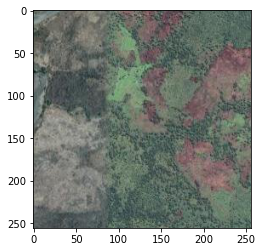

In [17]:
# Verify batch has legit images
for batch in train_loader:
    imgs, labels = batch
    index = 5
    print(f"Is crop: {labels[index]}")
    plt.imshow(imgs[index][0].permute(1, 2, 0))
    break

# 6. Baseline model
Will be running in colab to use GPU
https://colab.research.google.com/drive/15jzLtP1I3ohmVxIFlhu1NwCSjx5cfOFQ?usp=sharing

# 7. Results comparison

In [25]:
# Ethiopia Tigray preds
from notebook_utils import get_validation_df
from sklearn.metrics import f1_score, accuracy_score

In [23]:
val_pixel_lstm = get_validation_df("Ethiopia_Tigray_2020").reset_index(drop=True)

Loading data into memory


Caching files: 100%|██████████| 499/499 [00:00<00:00, 1633.50it/s]


In [18]:
val_spatial_awareness = pd.read_csv("/Users/izvonkov/Desktop/spatial_awareness_with_crop_preds.csv")

In [36]:
# Sanity check
(val_spatial_awareness["crop_probability"] == val_pixel_lstm["y_true"]).all()

True

In [37]:
y_true = val_spatial_awareness["crop_probability"]

In [38]:
f1_score(val_pixel_lstm["y_pred"], y_true)

0.6584615384615384

In [39]:
f1_score(val_spatial_awareness["spatial_awareness_preds"] > 0.5, y_true)

0.4721311475409836

In [35]:
combined = (val_spatial_awareness["spatial_awareness_preds"] + val_pixel_lstm["y_pred_decimal"])/2

In [41]:
f1_score(combined > 0.5, y_true)

0.6410256410256409

In [42]:
accuracy_score(combined > 0.5, y_true)

0.7755511022044088